In [1]:
import vtk
reader = vtk.vtkPolyDataReader()
reader.SetFileName('/vol/biomedic3/bglocker/brainshapes/1000596/T1_first-BrStem_first.vtk')
reader.Update()
mesh_ref = reader.GetOutput()

In [2]:
def view_mesh(input_mesh):
    colors = vtk.vtkNamedColors()
    
    lut = vtk.vtkLookupTable()
    lut.SetNumberOfColors(256)
    lut.Build()

    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputData(input_mesh)
    mapper.ScalarVisibilityOn()
    mapper.SetScalarModeToUsePointData()
    mapper.SetLookupTable(lut)

    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(colors.GetColor3d('White'))

    renderer = vtk.vtkRenderer()
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindowInteractor = vtk.vtkRenderWindowInteractor()
    renderWindowInteractor.SetRenderWindow(renderWindow)

    renderer.AddActor(actor)
    renderer.SetBackground(colors.GetColor3d('White'))
    renderer.GetActiveCamera().Pitch(90)
    renderer.GetActiveCamera().SetViewUp(0, 0, 1)
    renderer.ResetCamera()

    renderWindow.SetSize(600, 600)
    renderWindow.Render()
    renderWindow.SetWindowName('Mesh View')
    renderWindowInteractor.Start()

In [3]:
def numpy_pts_to_mesh(input_mesh, pts_array):
    new_mesh = vtk.vtkPolyData()
    new_mesh.DeepCopy(input_mesh)
    points = vtk.vtkPoints()
    for i in range(new_mesh.GetNumberOfPoints()):
        points.InsertNextPoint(pts_array[0,i], pts_array[1,i], pts_array[2,i])
    new_mesh.SetPoints(points)    
    return new_mesh

def numpy_scalars_to_mesh(input_mesh, scalars_array):
    new_mesh = vtk.vtkPolyData()
    new_mesh.DeepCopy(input_mesh)
    scalars = vtk.vtkFloatArray()
    for i in range(new_mesh.GetNumberOfPoints()):
        scalars.InsertNextTuple1(scalars_array[i])
    new_mesh.GetPointData().SetScalars(scalars)
    return new_mesh

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def umeyama_rigid(X, Y):
    
    # Get dimension and number of points
    m, n = X.shape
    
    # Demean the point sets X and Y
    X_mean = X.mean(1)
    Y_mean = Y.mean(1)

    X_demean =  X - np.tile(X_mean, (n, 1)).T
    Y_demean =  Y - np.tile(Y_mean, (n, 1)).T
    
    # Computing matrix XY' using demeaned point sets
    XY = np.dot(X_demean, Y_demean.T)

    # Singular value decomposition
    U,D,V = np.linalg.svd(XY,full_matrices=True,compute_uv=True)
    V=V.T.copy()
    
    # Determine rotation
    R = np.dot( V, U.T)

    # Determine translation
    t = Y_mean - np.dot(R, X_mean)
    
    return R,t

In [7]:
def umeyama_similarity(X, Y):
    
    # Get dimension and number of points
    m, n = X.shape

    # Demean the point sets X and Y
    X_mean = X.mean(1) #MODEL ANSWER
    Y_mean = Y.mean(1) #MODEL ANSWER
    
    X_demean =  X - np.tile(X_mean, (n, 1)).T #MODEL ANSWER
    Y_demean =  Y - np.tile(Y_mean, (n, 1)).T #MODEL ANSWER

    # Computing matrix XY' using demeaned and NORMALISED point sets (divide by the number of points n)
    # See Equation (38) in the paper
    XY = np.dot(X_demean, Y_demean.T) / n  #MODEL ANSWER

    # Determine variances of points X and Y, see Equation (36),(37) in the paper
    X_var = np.mean(np.sum(X_demean*X_demean, 0))
    Y_var = np.mean(np.sum(Y_demean*Y_demean, 0))

    # Singular value decomposition
    U,D,V = np.linalg.svd(XY,full_matrices=True,compute_uv=True)
    V=V.T.copy()
    
    # Determine rotation
    R = np.dot( V, U.T) #MODEL ANSWER
    
    # Determine the scaling, see Equation (42) in the paper (assume S to be the identity matrix, so ignore)
    c = np.trace(np.diag(D)) / X_var #MODEL ANSWER

    # Determine translation, see Equation (41) in the paper
    t = Y_mean - c * np.dot(R, X_mean) #MODEL ANSWER

    return R,t,c

In [8]:
def read_vtk(filename):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(filename)
    reader.Update()
    polydata = reader.GetOutput()
    vertices = np.array([polydata.GetPoint(i) for i in range(polydata.GetNumberOfPoints())])
    return vertices

In [9]:
from pathlib import Path

pts = []
for path in Path('/vol/biomedic3/bglocker/brainshapes').rglob('*BrStem*.vtk'):
    v = read_vtk(str(path))
    v = np.hstack( (v[:,0], v[:,1], v[:,2]) )
    pts.append(v)
    break
pts = np.array(pts).transpose()

In [10]:
m, n = pts.shape

num_centroids = m//3;
x_ind = range(num_centroids)
y_ind = range(num_centroids,num_centroids*2)
z_ind = range(num_centroids*2,num_centroids*3)

cx = pts[x_ind,:];
cy = pts[y_ind,:];
cz = pts[z_ind,:];

print('Dimension:\t' + str(m))
print('Samples:\t' + str(n))

Dimension:	1926
Samples:	1


In [11]:
from mpl_toolkits.mplot3d import Axes3D

def plot_pts(x,y,z,max_range=None,marker_size=10,figure_size=5):

    fig = plt.figure(figsize=(figure_size, figure_size), dpi=100)
    ax = fig.gca(projection='3d')
    for s in range(x.shape[1]):
        ax.scatter(x[:,s], y[:,s], z[:,s], s=marker_size, marker='.')

    if max_range == None:
        max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0

    mid_x = (x.max()+x.min()) * 0.5
    mid_y = (y.max()+y.min()) * 0.5
    mid_z = (z.max()+z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    ax.view_init(10,45)
    ax.grid()

<ipython-input-11-09eccd28964a>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


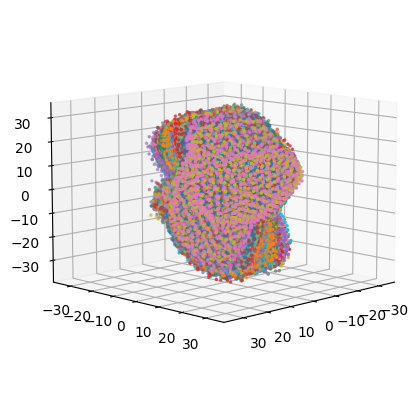

In [12]:
# spatial normalisation
cx_norm = cx - np.tile(np.mean(cx,axis=0),(num_centroids,1))
cy_norm = cy - np.tile(np.mean(cy,axis=0),(num_centroids,1))
cz_norm = cz - np.tile(np.mean(cz,axis=0),(num_centroids,1))

plot_pts(cx_norm, cy_norm, cz_norm, marker_size=10)

In [13]:
id_source = 0
id_target = 3

source = np.vstack( (cx[:,id_source], cy[:,id_source], cz[:,id_source]) )
target = np.vstack( (cx[:,id_target], cy[:,id_target], cz[:,id_target]) )

<ipython-input-11-09eccd28964a>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


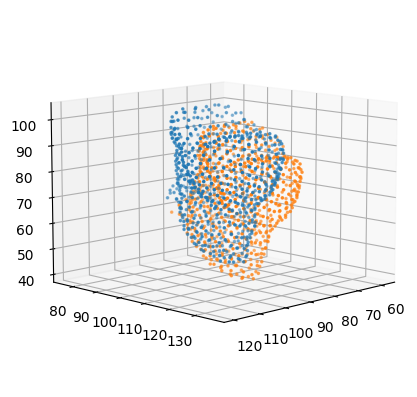

In [14]:
shapes_x = np.vstack((source[0,:], target[0,:])).transpose()
shapes_y = np.vstack((source[1,:], target[1,:])).transpose()
shapes_z = np.vstack((source[2,:], target[2,:])).transpose()
plot_pts( shapes_x, shapes_y, shapes_z, marker_size=10 )

<ipython-input-11-09eccd28964a>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


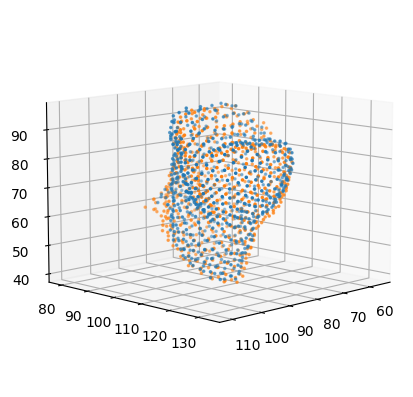

In [15]:
R, t = umeyama_rigid(source, target)
warped = np.dot(R,source) + np.tile(t, (num_centroids, 1)).transpose()

shapes_x = np.vstack((warped[0,:], target[0,:])).transpose()
shapes_y = np.vstack((warped[1,:], target[1,:])).transpose()
shapes_z = np.vstack((warped[2,:], target[2,:])).transpose()
plot_pts( shapes_x, shapes_y, shapes_z, marker_size=10 )

In [16]:
def registration(cx, cy, cz, num_centroids, use_rigid=True):
    id_target = 0

    target = np.vstack( (cx[:,id_target], cy[:,id_target], cz[:,id_target]) )

    cx_norm[:,id_target] = target[0,:]
    cy_norm[:,id_target] = target[1,:]
    cz_norm[:,id_target] = target[2,:]

    for i in range(1, n):
        source = np.vstack( (cx[:,i], cy[:,i], cz[:,i]) )

        if use_rigid:
            R, t = umeyama_rigid(source, target)        
            warped = np.dot(R,source) + np.tile(t, (num_centroids, 1)).transpose()
        else:
            R, t, c = umeyama_similarity(source, target)
            warped = c * np.dot(R,source) + np.tile(t, (num_centroids, 1)).transpose()

        cx_norm[:,i] = warped[0,:]
        cy_norm[:,i] = warped[1,:]
        cz_norm[:,i] = warped[2,:]
    
    return cx_norm, cy_norm, cz_norm

<ipython-input-11-09eccd28964a>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


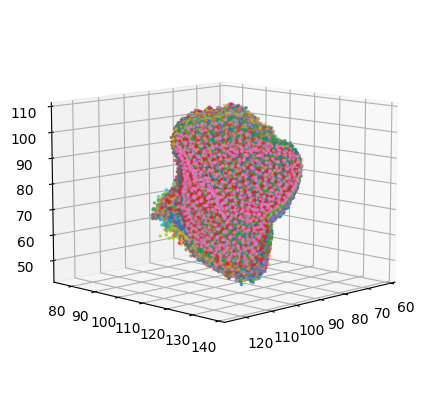

In [30]:
# Switch here between the two methods.
use_rigid = True

cx_norm, cy_norm, cz_norm = registration(cx, cy, cz, num_centroids, use_rigid=use_rigid)
    
plot_pts(cx_norm, cy_norm, cz_norm, marker_size=10)

<ipython-input-11-09eccd28964a>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


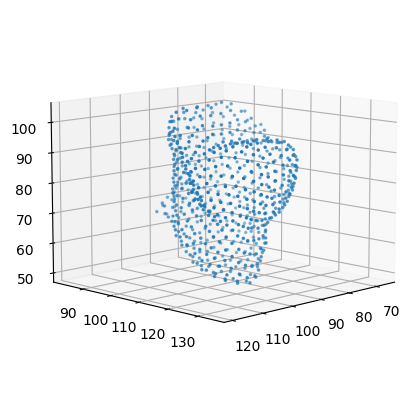

In [31]:
cx_mean = np.mean(cx_norm,axis=1)
cy_mean = np.mean(cy_norm,axis=1)
cz_mean = np.mean(cz_norm,axis=1)

plot_pts(cx_mean.reshape(-1,1), cy_mean.reshape(-1,1), cz_mean.reshape(-1,1), marker_size=10)

In [32]:
mean_pts_array = np.vstack( (cx_mean, cy_mean, cz_mean) )
mesh_mean = numpy_pts_to_mesh(mesh_ref, mean_pts_array)

In [33]:
# view_mesh(mesh_mean)

In [34]:
import sklearn.decomposition as decomp

X = np.vstack((cx_norm, cy_norm, cz_norm))
m, n = X.shape
print('Dimension:\t' + str(m))
print('Samples:\t' + str(n))

Dimension:	1926
Samples:	14502


In [35]:
# Create PCA instance
pca = decomp.PCA()

# Fit the data
pca.fit(X.T)

# Get the mean from PCA
mu_X = pca.mean_

# Get principal modes (a.k.a. components) from PCA
U = pca.components_.T

# Get the eigenvalues from PCA's singular values
D = pca.singular_values_**2 / (n - 1)

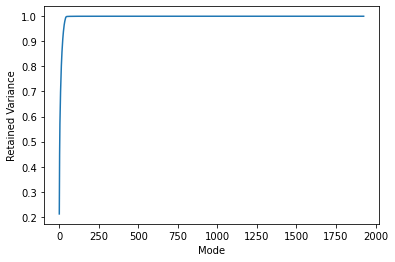

In [36]:
# Plot retained variance
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('Mode')
ax.set_ylabel('Retained Variance')
plt.show()

<ipython-input-11-09eccd28964a>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


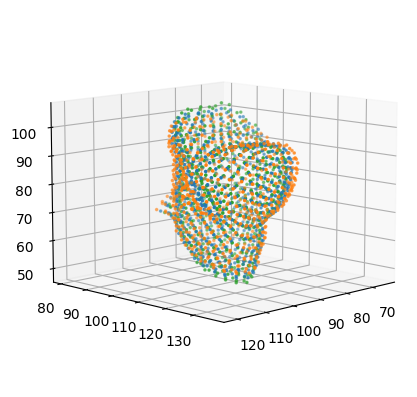

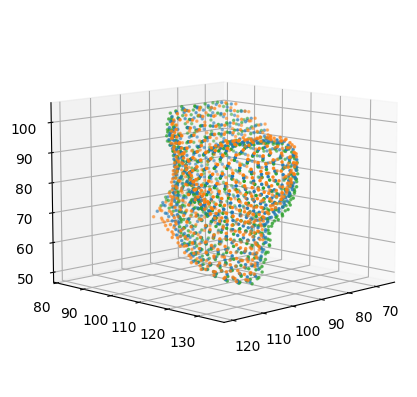

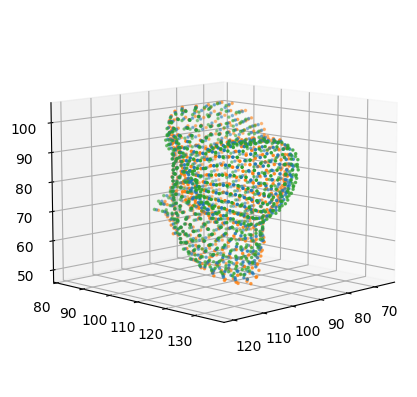

In [37]:
num_modes = 3
for i in range(num_modes):

    # add and subtract 2 times the standard deviation from the mean
    sp = mu_X + U[:,i] * np.sqrt(D[i]) * 3
    sn = mu_X - U[:,i] * np.sqrt(D[i]) * 3
    
    cxx = np.vstack((mu_X[x_ind], sp[x_ind], sn[x_ind])).T
    cyy = np.vstack((mu_X[y_ind], sp[y_ind], sn[y_ind])).T
    czz = np.vstack((mu_X[z_ind], sp[z_ind], sn[z_ind])).T
        
    plot_pts(cxx, cyy, czz, marker_size=10)

In [38]:
from ipywidgets import interact, fixed

def plot_points(mean_shape,modes,s1,s2,s3,s4,s5,s6):
    spine = mu_X + U[:,0] * s1 + U[:,1] * s2 + U[:,2] * s3 + U[:,3] * s4 + U[:,4] * s5 + U[:,5] * s6
    sx = spine[x_ind].reshape(-1,1)
    sy = spine[y_ind].reshape(-1,1)
    sz = spine[z_ind].reshape(-1,1)
    plot_pts(sx, sy, sz, max_range=30, marker_size=10)

def interactive_pca(mu_X,U,D):
    interact(plot_points,mean_shape=fixed(mu_X),modes=fixed(U),
             **{'s%d' % (i+1): (-np.sqrt(D[i]) * 10, np.sqrt(D[i]) * 10, np.sqrt(D[i])) for i in range(6)});

interactive_pca(mu_X,U,D)

interactive(children=(FloatSlider(value=0.0, description='s1', max=126.52443707556834, min=-126.52443707556834…

In [39]:
reg_dict = {
    'mu_X': mu_X,
    'U': U,
    'D': D,
    'mean_pts_array': mean_pts_array,
}

np.save('rigid_decomp.npy', reg_dict)
# np.save('rigid_sim_decomp.npy', reg_dict)

## Plotting Rigid vs Similarity Registration

In [5]:
import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')

import pyvista as pv
pv.set_plot_theme("document")

template_path = '/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-BrStem_first.vtk'
template = pv.read(template_path)

from coma.utils.visualise import plot_mesh_pyvista, plot_meshes_pyvista

In [6]:
# calculate distance map when comparing mean shape to a specific mode of variation
rigid_reg_dict = np.load('rigid_decomp.npy', allow_pickle=True)[()]
sim_reg_dict = np.load('rigid_sim_decomp.npy', allow_pickle=True)[()]

m = template.points.shape[0] * template.points.shape[1]
num_centroids = m // 3;
x_ind = range(num_centroids)
y_ind = range(num_centroids,num_centroids*2)
z_ind = range(num_centroids*2,num_centroids*3)

modes = 5

polydatas = []
colors = []

for _reg_dict in [rigid_reg_dict, sim_reg_dict]:
    mu_X = _reg_dict['mu_X']
    U = _reg_dict['U']
    D = _reg_dict['D']
    mean_pts_array = _reg_dict['mean_pts_array']
    
    for mode in range(modes):
        sp = mu_X + U[:,mode] * np.sqrt(D[mode]) * 3
        diff = mean_pts_array - np.vstack( (sp[x_ind], sp[y_ind], sp[z_ind]) )
        diff = np.linalg.norm(diff, axis=0)
        colors.append(np.expand_dims(diff, 0))
        template_copy = template.copy()
        template_copy.points = mean_pts_array.T
        polydatas.append(template_copy)

In [7]:
width = 768 * 2
height = int(width / (1.618 / 0.8))

rotations = [
    (-10, 0, 240), (0, 0, 270), (-5, 0, -45), (0, 0, 10), (-10, 0, 95),
    (0, 0, 270), (-5, 0, -45), (0, 0, 10), (-10, 0, 95), (0, 0, 50),
]

plotter = pv.Plotter(
    shape=(2, 5),
    window_size=(width, height),
    border=False,
    lighting='light_kit',
    off_screen=True,
    notebook=True,
)

plot_meshes_pyvista(
    plotter,
    polydatas,
    rotations=rotations * 2,  # rotations * n_modes * n_laps,
    vertexcolors=np.concatenate(colors, axis=0),
    vertexscalar='distance',
    scalar_bar_idx=len(colors) - 1, # n_modes * n_laps - 1,
    titles=[f'Mode {x}' for x in range(1, 6)],  #  + [''] * 5,
    mesh_kwargs=dict(
        smooth_shading=True,
    ),
    scalar_bar_kwargs=dict(
        label_font_size=10,
        position_x=0.85,
        title_font_size=10,
        shadow=True,
        n_labels=2,
        fmt='%.2fmm^2',
    ),
    title_kwargs=dict(
        font_size=8,
        font='arial',
    ),
#     cmap='Blues_r',
)

plotter.subplot(0, 0)
actor = plotter.add_text('rigid', position='left_edge', font_size=8)
plotter.subplot(1, 0)
actor = plotter.add_text('sim.', position='left_edge', font_size=8)

plotter.show(screenshot='shape_modes_sim_rigid.png')

AssertionError: 